#Primera parte: Manipulación y preparación de datos


Este notebook presenta el Análisis Exploratorio de Datos (EDA) y la preparación de los datos del proyecto. El objetivo es entender, limpiar y preparar el dataset para entrenar modelos de Machine Learning.

**Los objetivos clave de este análisis son los siguientes:**

🔎**Importación y Análisis Preliminar:** Inspeccionar la estructura del dataset, sus tipos de datos y estadísticas descriptivas.

🧽**Depuración de Datos:** Identificar y gestionar valores ausentes, registros duplicados, inconsistencias y valores atípicos.

👓**Análisis Exploratorio de Datos (EDA):** Emplear visualizaciones para descubrir patrones, distribuciones y correlaciones entre las variables.

#--- Importar librerías ---

In [6]:
# Manipulación de datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import seaborn as sns

#Otros
import re
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown


#--- Funciones ---

In [7]:
#Función para limpieza

def clean_dataframe(df):
    """
    Limpia un DataFrame aplicando un conjunto de reglas:
    - Elimina columnas innecesarias.
    - Convierte todo a minúsculas y quita espacios en blanco al inicio y al final.
    - Reemplaza variaciones de 'nan' con el valor nulo estándar de NumPy.
    - Aplica la limpieza específica para la columna 'Performance'.
    - Devuelve un nuevo DataFrame limpio y preprocesado.

    Args:
        df (pd.DataFrame): El DataFrame de entrada que se va a limpiar.

    Returns:
        pd.DataFrame: Un nuevo DataFrame limpio y preprocesado.
    """
    # 1. Crear una copia para no modificar el DataFrame original
    df_cleaned = df.copy()

    # 2. Eliminar columnas innecesarias (si existen)
    cols_to_drop = ['mixed_type_col']
    # Busca qué columnas de la lista de eliminación realmente existen en el DataFrame
    existing_cols_to_drop = [col for col in cols_to_drop if col in df_cleaned.columns]
    if existing_cols_to_drop:
        df_cleaned = df_cleaned.drop(columns=existing_cols_to_drop)
        print(f"Columnas eliminadas: {existing_cols_to_drop}")

    # 3. Limpieza general de todas las columnas de texto (tipo 'object')
    # Itera solo sobre las columnas que son de tipo texto
    for col in df_cleaned.select_dtypes(include=['object']).columns:
        # Convierte todo a minúsculas y quita espacios en blanco al inicio y al final
        df_cleaned[col] = df_cleaned[col].str.lower().str.strip()

        # Reemplaza variaciones de 'nan' con el valor nulo estándar de NumPy
        df_cleaned[col] = df_cleaned[col].replace(r'^(nan|none|na|n/a)$', np.nan, regex=True)

    # 4. Limpieza específica para la columna 'Performance'
    # Define la función de limpieza para las categorías de rendimiento
    def clean_performance_categories(performance):
        # Si el valor es nulo (NaN), lo dejamos como está
        if pd.isna(performance):
            return np.nan

        # Usamos expresiones regulares para estandarizar las categorías
        if re.search(r'excellent', performance):
            return 'Excellent'
        elif re.search(r'vg', performance):
            return 'Vg'
        elif re.search(r'good', performance):
            return 'Good'
        elif re.search(r'average', performance):
            return 'Average'
        else:
            return performance # Devuelve el valor original si no coincide con ninguna categoría

    # Aplica la limpieza solo si la columna 'Performance' existe
    if 'Performance' in df_cleaned.columns:
        df_cleaned['Performance'] = df_cleaned['Performance'].apply(clean_performance_categories)
        print("Columna 'Performance' estandarizada.")

    return df_cleaned

# --- Ejemplo de Uso ---
if __name__ == '__main__':
    # Crear un DataFrame de ejemplo con datos "sucios"
    data = {
        'ID': [1, 2, 3, 4, 5, 6],
        'Performance': ['  excellent ', 'vg (very good)', 'good', 'AVERAGE', 'NAN', 'good '],
        'comment': [' a comment ', 'another one', '  final comment ', 'nan', '  ', 'none'],
        'mixed_type_col': [1, 'text', 3.0, 'other', 5, 6] # Columna a eliminar
    }
    dirty_df = pd.DataFrame(data)

    print("--- DataFrame Original ---")
    print(dirty_df)
    print("\n")

    # Aplicar la función de limpieza
    cleaned_df = clean_dataframe(dirty_df)

    print("\n--- DataFrame Limpio ---")
    print(cleaned_df)
    print("\nTipos de datos después de la limpieza:")
    print(cleaned_df.info())

--- DataFrame Original ---
   ID     Performance           comment mixed_type_col
0   1      excellent         a comment               1
1   2  vg (very good)       another one           text
2   3            good    final comment             3.0
3   4         AVERAGE               nan          other
4   5             NAN                                5
5   6           good               none              6


Columnas eliminadas: ['mixed_type_col']
Columna 'Performance' estandarizada.

--- DataFrame Limpio ---
   ID Performance        comment
0   1   Excellent      a comment
1   2          Vg    another one
2   3        Good  final comment
3   4     Average            NaN
4   5         NaN               
5   6        Good            NaN

Tipos de datos después de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           6 non-null  

In [8]:
#Función para hacer EDA

def resumen_eda_categoricas(df: pd.DataFrame, target_column: str = None):
    """
    Realiza un análisis exploratorio enfocado en las variables categóricas de un DataFrame.

    Esta función imprime un resumen que incluye:
    1. Dimensiones del DataFrame.
    2. Una muestra de los datos.
    3. Conteo de valores nulos.
    4. Estadísticas descriptivas para variables categóricas (conteo, únicos, moda).
    5. Distribución de la variable objetivo (si es categórica).

    Args:
        df (pd.DataFrame): El DataFrame que se va a analizar.
        target_column (str, optional): El nombre de la columna objetivo categórica.
                                     Si se proporciona, se mostrará su distribución.
    """
    # Selecciona solo las columnas categóricas para el análisis principal
    df_cat = df.select_dtypes(include=['object', 'category'])

    # Imprime un título principal para el reporte
    display(Markdown("---"))
    display(Markdown("## **Análisis Exploratorio de Variables Categóricas**"))
    display(Markdown("---"))

    # 1. Dimensiones del DataFrame
    display(Markdown("### 1. Dimensiones del Dataset"))
    print(f"Número de Filas:    {df.shape[0]:,}")
    print(f"Número de Columnas Categóricas: {df_cat.shape[1]} (de un total de {df.shape[1]})")
    print("\n")

    # 2. Muestra aleatoria de los datos
    display(Markdown("### 2. Muestra Aleatoria de Datos"))
    display(df.sample(5))
    print("\n")

    # 3. Calidad de los Datos (Nulos y Duplicados en todo el DF)
    display(Markdown("### 3. Calidad de los Datos"))
    nulos = df.isnull().sum()
    # duplicados = df.duplicated().sum() # Removed duplicate check
    # print(f"Número total de filas duplicadas: {duplicados}") # Removed duplicate check
    print("Conteo de valores nulos por columna:")
    if nulos.sum() == 0:
        print("No se encontraron valores nulos.")
    else:
        # Muestra solo las columnas que tienen valores nulos
        print(nulos[nulos > 0].sort_values(ascending=False))
    print("\n")

    # 4. Estadísticas Descriptivas de Variables Categóricas
    display(Markdown("### 4. Resumen de Variables Categóricas"))
    if df_cat.empty:
        print("No se encontraron variables categóricas en el DataFrame.")
    else:
        display(df_cat.describe().T)
    print("\n")

    # 5. Análisis de la Variable Objetivo
    if target_column:
        if target_column in df.columns:
            # Verifica que la columna objetivo sea categórica
            if df[target_column].dtype in ['object', 'category']:
                display(Markdown(f"### 5. Distribución de la Variable Objetivo: '{target_column}'"))
                distribucion = pd.DataFrame({
                    'Frecuencia': df[target_column].value_counts(),
                    'Porcentaje (%)': df[target_column].value_counts(normalize=True).mul(100).round(2)
                })
                display(distribucion)
            else:
                print(f"Advertencia: La columna objetivo '{target_column}' no es de tipo categórico.")
        else:
            print(f"Advertencia: La columna objetivo '{target_column}' no se encontró en el DataFrame.")

# --- Ejemplo de Uso ---
if __name__ == '__main__':
    # Crear un DataFrame de ejemplo
    data = {
        'ID_numerico': [101, 102, 103, 104, 105, 101],
        'Producto': ['Laptop', 'Mouse', 'Teclado', 'Laptop', 'Monitor', 'Laptop'],
        'Categoria': ['Electronica', 'Perifericos', 'Perifericos', 'Electronica', 'Pantallas', 'Electronica'],
        'Estado': ['Nuevo', 'Usado', 'Nuevo', 'Nuevo', None, 'Nuevo'],
        'Precio': [1200, 25, 75, 1150, 300, 1200]
    }
    sample_df = pd.DataFrame(data)

    # Ejecutar la función de análisis
    resumen_eda_categoricas(sample_df, target_column='Categoria')

---

## **Análisis Exploratorio de Variables Categóricas**

---

### 1. Dimensiones del Dataset

Número de Filas:    6
Número de Columnas Categóricas: 3 (de un total de 5)




### 2. Muestra Aleatoria de Datos

,ID_numerico,Producto,Categoria,Estado,Precio
4,105,Monitor,Pantallas,None,300
3,104,Laptop,Electronica,Nuevo,1150
0,101,Laptop,Electronica,Nuevo,1200
2,103,Teclado,Perifericos,Nuevo,75
1,102,Mouse,Perifericos,Usado,25


### 3. Calidad de los Datos

Conteo de valores nulos por columna:
Estado    1
dtype: int64




### 4. Resumen de Variables Categóricas

,count,unique,top,freq
Producto,6,4,Laptop,3
Categoria,6,3,Electronica,3
Estado,5,2,Nuevo,4


### 5. Distribución de la Variable Objetivo: 'Categoria'

,Frecuencia,Porcentaje (%)
Categoria,,
Electronica,3,50.00
Perifericos,2,33.33
Pantallas,1,16.67


In [9]:
#Función para valores nulos

import pandas as pd
import numpy as np
from IPython.display import display, Markdown

def analizar_y_eliminar_faltantes(df: pd.DataFrame):
    """
    Analiza los valores faltantes del dataset, elimina las filas que los contienen
    y devuelve un reporte completo del proceso.

    Args:
        df (pd.DataFrame): El DataFrame de entrada que puede contener valores nulos.

    Returns:
        pd.DataFrame: Un nuevo DataFrame sin filas que contengan valores nulos.
    """
    display(Markdown("---"))
    display(Markdown("## **Análisis y Gestión de Valores Faltantes**"))
    display(Markdown("---"))

    # 1. Analizar el DataFrame original
    display(Markdown("### 1. Resumen en el DataFrame Original"))

    # Calcula el conteo y porcentaje de valores faltantes
    valores_faltantes = df.isnull().sum()
    porcentaje_faltantes = (valores_faltantes / len(df) * 100).round(2)

    # Crea un resumen para mostrarlo
    resumen_faltantes = pd.DataFrame({
        'Valores Faltantes': valores_faltantes,
        'Porcentaje (%)': porcentaje_faltantes
    })

    # Muestra solo las columnas que tienen valores faltantes para un reporte limpio
    resumen_filtrado = resumen_faltantes[resumen_faltantes['Valores Faltantes'] > 0]

    if resumen_filtrado.empty:
        print("¡Excelente! No se encontraron valores faltantes en el DataFrame. ✨")
        return df.copy() # Devuelve una copia si no hay nada que hacer
    else:
        print("Se encontraron los siguientes valores faltantes:")
        display(resumen_filtrado.sort_values(by='Porcentaje (%)', ascending=False))

    # 2. Limpiar el DataFrame eliminando filas con valores nulos
    df_cleaned = df.dropna()

    # 3. Mostrar el impacto de la limpieza
    display(Markdown("### 2. Impacto de la Eliminación de Filas"))
    print(f"Número de filas en el DataFrame original: {df.shape[0]:,}")
    print(f"Número de filas después de la limpieza:  {df_cleaned.shape[0]:,}")
    filas_eliminadas = df.shape[0] - df_cleaned.shape[0]
    porcentaje_eliminado = round((filas_eliminadas / df.shape[0] * 100), 2) # Apply round to the result
    print(f"Total de filas eliminadas: {filas_eliminadas:,} ({porcentaje_eliminado}%) 🗑️")

    display(Markdown("\n### 3. Verificación del DataFrame Limpio"))
    print("Primeras 5 filas del DataFrame resultante:")
    display(df_cleaned.head())

    # Confirma que ya no hay valores nulos
    if df_cleaned.isnull().sum().sum() == 0:
        print("\nConfirmado: No quedan valores faltantes en el nuevo DataFrame. ✅")

    return df_cleaned

# --- Ejemplo de Uso ---
if __name__ == '__main__':
    # Crear un DataFrame de ejemplo con datos faltantes
    data = {
        'ID': [1, 2, 3, 4, 5, 6],
        'Producto': ['Laptop', 'Mouse', np.nan, 'Laptop', 'Monitor', 'Teclado'],
        'Precio': [1200, 25, 75, 1150, np.nan, 80],
        'Stock': [10, 150, 40, 5, 20, np.nan]
    }
    sample_df = pd.DataFrame(data)

    # Ejecutar la función
    # La función imprimirá el reporte completo y devolverá el DataFrame limpio
    df_limpio = analizar_y_eliminar_faltantes(sample_df)

---

## **Análisis y Gestión de Valores Faltantes**

---

### 1. Resumen en el DataFrame Original

Se encontraron los siguientes valores faltantes:


,Valores Faltantes,Porcentaje (%)
Producto,1,16.67
Precio,1,16.67
Stock,1,16.67


### 2. Impacto de la Eliminación de Filas

Número de filas en el DataFrame original: 6
Número de filas después de la limpieza:  3
Total de filas eliminadas: 3 (50.0%) 🗑️



### 3. Verificación del DataFrame Limpio

Primeras 5 filas del DataFrame resultante:


,ID,Producto,Precio,Stock
0,1,Laptop,1200.0,10.0
1,2,Mouse,25.0,150.0
3,4,Laptop,1150.0,5.0



Confirmado: No quedan valores faltantes en el nuevo DataFrame. ✅


--- Generando visualizaciones para variables cualitativas ---


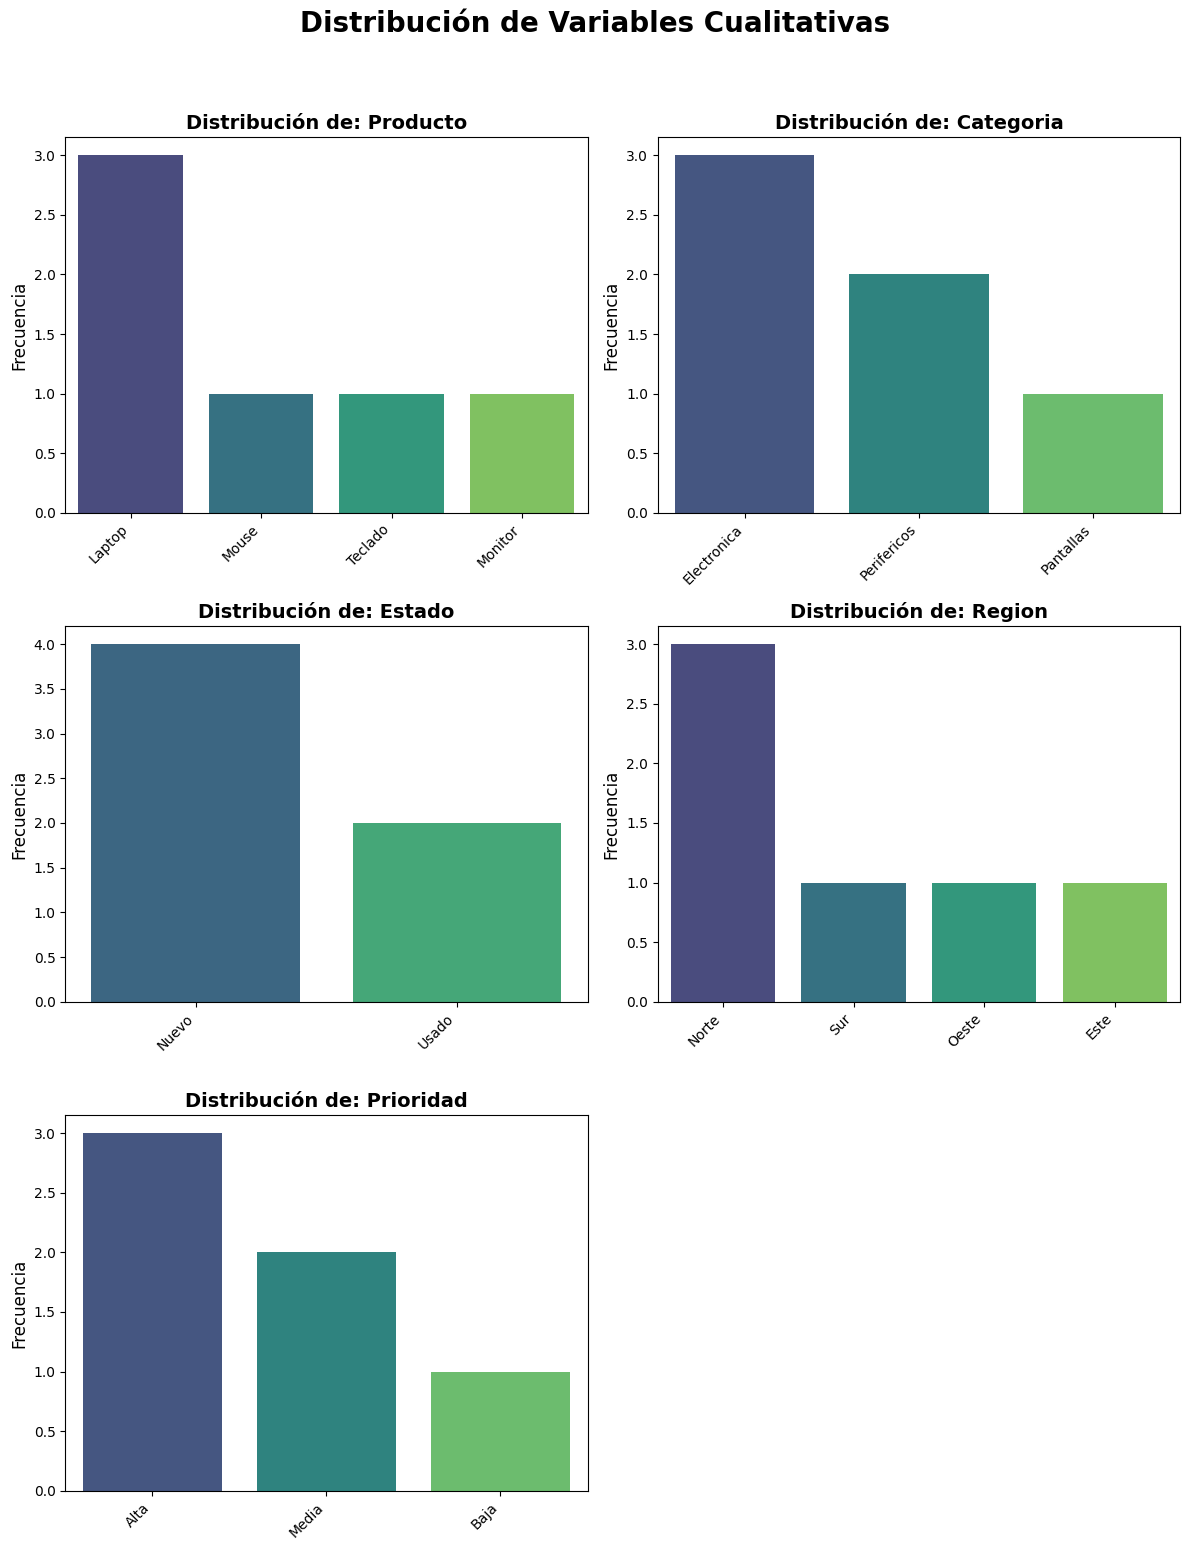

In [10]:
#Función para gráficas de variables cualitativas


def visualizar_cualitativas(df: pd.DataFrame, exclude_cols: list = None, n_cols: int = 3, color: str = 'lightpink'):
    """
    Crea una grilla de gráficos de barras (countplots) para cada variable cualitativa
    en el DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame que contiene los datos.
        exclude_cols (list, optional): Una lista de nombres de columnas a excluir de la
                                     visualización. Defaults to None.
        n_cols (int, optional): El número de columnas en la grilla de subplots.
                                Defaults to 3.
        color (str, optional): El color de las barras en los gráficos.
                               Defaults to 'lightpink'.
    """
    print("--- Generando visualizaciones para variables cualitativas ---")

    # 1. Seleccionar columnas cualitativas (tipo 'object' o 'category')
    qualitative_cols = df.select_dtypes(include=['object', 'category']).columns

    # 2. Excluir las columnas especificadas en `exclude_cols`
    if exclude_cols:
        # Asegurarse de que exclude_cols es una lista
        if not isinstance(exclude_cols, list):
            exclude_cols = [exclude_cols]
        qualitative_cols = qualitative_cols.drop([col for col in exclude_cols if col in qualitative_cols])

    # 3. Comprobar si hay algo que graficar
    if qualitative_cols.empty:
        print("No se encontraron columnas cualitativas para visualizar después de excluir las especificadas.")
        return

    # 4. Calcular el tamaño de la grilla y crear los subplots
    n_rows = (len(qualitative_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
    axes = axes.ravel() # Aplanar el array de ejes para iterar fácilmente

    # 5. Iterar y crear un gráfico para cada columna
    for i, col in enumerate(qualitative_cols):
        # Ordenar las barras por frecuencia
        order = df[col].value_counts().index
        sns.countplot(x=col, data=df, order=order, ax=axes[i], color=color, palette='viridis')

        axes[i].set_title(f'Distribución de: {col}', fontsize=14, weight='bold')
        axes[i].set_xlabel('') # Etiqueta X opcional, a veces es redundante
        axes[i].set_ylabel('Frecuencia', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)
        # Ajustar las etiquetas para que no se superpongan
        axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right')

    # 6. Ocultar los ejes vacíos que no se usaron
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Distribución de Variables Cualitativas', fontsize=20, weight='bold', y=1.03)
    plt.tight_layout()
    plt.show()


# --- Ejemplo de Uso ---
if __name__ == '__main__':
    # Crear un DataFrame de ejemplo
    data = {
        'Producto': ['Laptop', 'Mouse', 'Teclado', 'Laptop', 'Monitor', 'Laptop'],
        'Categoria': ['Electronica', 'Perifericos', 'Perifericos', 'Electronica', 'Pantallas', 'Electronica'],
        'Estado': ['Nuevo', 'Usado', 'Nuevo', 'Nuevo', 'Usado', 'Nuevo'],
        'Region': ['Norte', 'Sur', 'Norte', 'Oeste', 'Este', 'Norte'],
        'Prioridad': ['Alta', 'Media', 'Media', 'Alta', 'Baja', 'Alta'],
        'Performance': ['Good', 'Excellent', 'Good', 'Average', 'Good', 'Excellent'] # Columna a excluir
    }
    sample_df = pd.DataFrame(data)

    # Llamar a la función para visualizar las variables
    # Excluimos 'Performance' y mostramos 2 gráficos por fila
    visualizar_cualitativas(sample_df, exclude_cols=['Performance'], n_cols=2)

--- Gráfico: Coaching vs. Performance ---


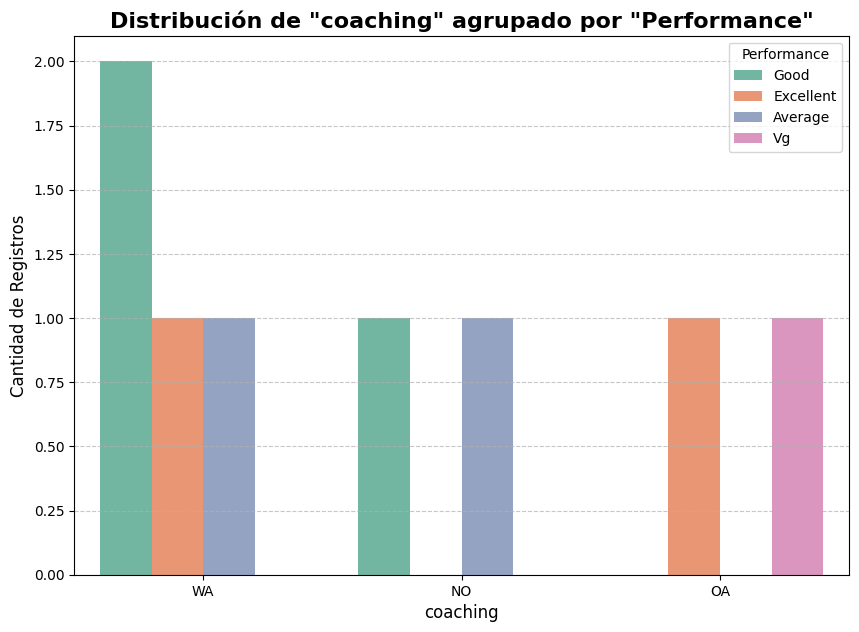


--- Gráfico con diferente paleta de colores ---


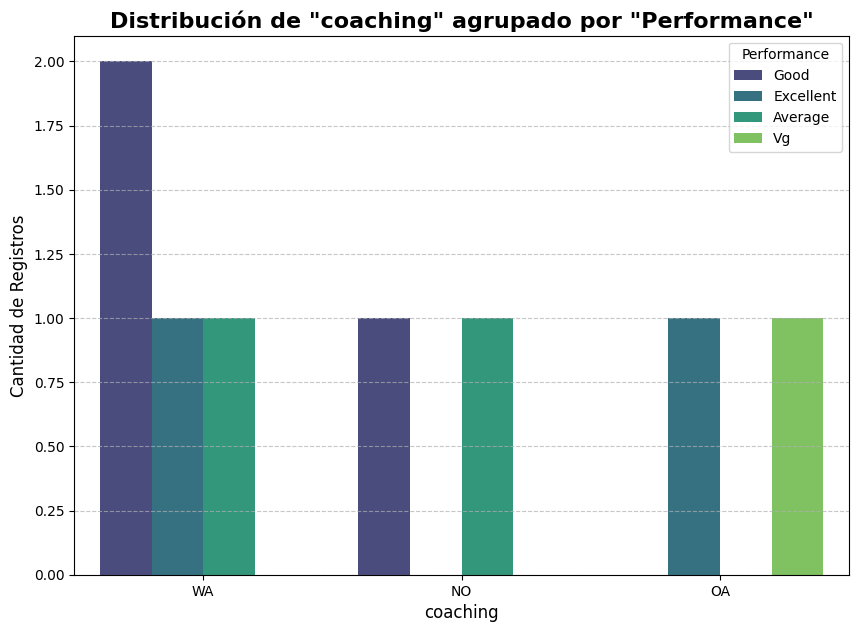


--- Gráfico: Género vs. Performance ---


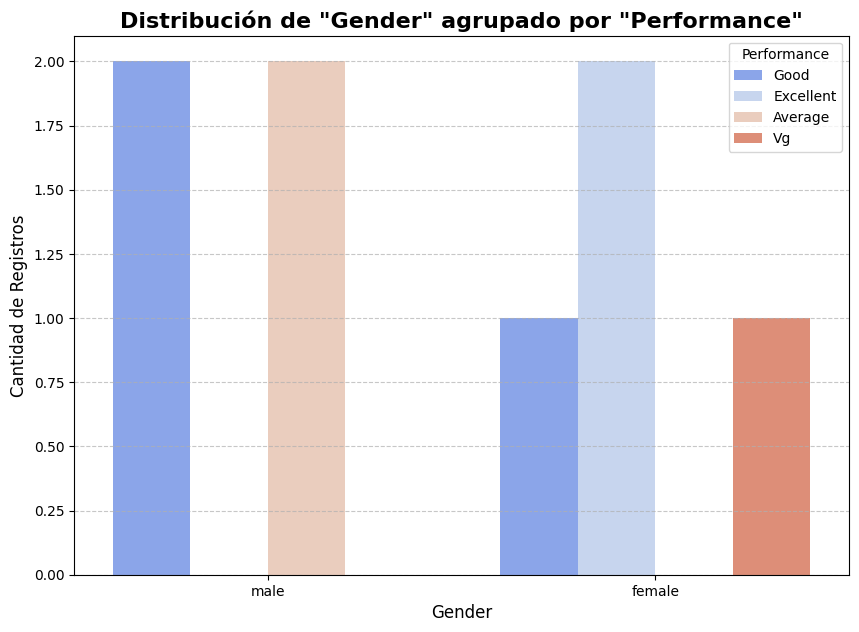

In [11]:
#Función para realizar gráficos de variable objetivo (Performance)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_grouped_countplot(df: pd.DataFrame, x_col: str, hue_col: str, palette: str = 'Set2', figsize: tuple = (10, 7)):
    """
    Crea un gráfico de barras (countplot) agrupado por una variable categórica (hue).

    Args:
        df (pd.DataFrame): El DataFrame que contiene los datos.
        x_col (str): El nombre de la columna para el eje X.
        hue_col (str): El nombre de la columna para agrupar y colorear las barras.
        palette (str, optional): La paleta de colores de seaborn a utilizar. Defaults to 'Set2'.
        figsize (tuple, optional): El tamaño de la figura (ancho, alto). Defaults to (10, 7).
    """
    # Verificar que las columnas existan en el DataFrame
    if x_col not in df.columns or hue_col not in df.columns:
        print(f"Error: Una o ambas columnas ('{x_col}', '{hue_col}') no se encontraron en el DataFrame.")
        return

    # Crear la figura y el gráfico
    plt.figure(figsize=figsize)
    sns.countplot(x=x_col, hue=hue_col, data=df, palette=palette)

    # Añadir títulos y etiquetas dinámicamente
    plt.title(f'Distribución de "{x_col}" agrupado por "{hue_col}"', fontsize=16, weight='bold')
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel('Cantidad de Registros', fontsize=12)
    plt.legend(title=hue_col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.show()

# --- Ejemplo de Uso (replicando tu gráfico original) ---
if __name__ == '__main__':
    # Crear un DataFrame de ejemplo
    data = {
        'coaching': ['WA', 'WA', 'NO', 'OA', 'WA', 'NO', 'WA', 'OA'],
        'Performance': ['Good', 'Excellent', 'Average', 'Excellent', 'Good', 'Good', 'Average', 'Vg'],
        'Gender': ['male', 'female', 'male', 'female', 'male', 'female', 'male', 'female']
    }
    df_cleaned = pd.DataFrame(data)

    # Llamar a la función para crear el gráfico específico de coaching vs performance
    print("--- Gráfico: Coaching vs. Performance ---")
    plot_grouped_countplot(df=df_cleaned, x_col='coaching', hue_col='Performance')

    # Otro ejemplo con las mismas columnas pero diferente paleta
    print("\n--- Gráfico con diferente paleta de colores ---")
    plot_grouped_countplot(df=df_cleaned, x_col='coaching', hue_col='Performance', palette='viridis')

    # Ejemplo con otras columnas del mismo DataFrame
    print("\n--- Gráfico: Género vs. Performance ---")
    plot_grouped_countplot(df=df_cleaned, x_col='Gender', hue_col='Performance', palette='coolwarm')

#--- Lectura de datos ---

In [12]:
try:
    df = pd.read_csv('student_entry_performance_modified.csv')
except FileNotFoundError:
    print("Asegúrate de que el archivo esté disponible.")
    exit()

#Análisis Exploratorio de Datos

#--- Análisis Inicial ---

In [13]:
resumen_eda_categoricas(df)

---

## **Análisis Exploratorio de Variables Categóricas**

---

### 1. Dimensiones del Dataset

Número de Filas:    679
Número de Columnas Categóricas: 13 (de un total de 13)




### 2. Muestra Aleatoria de Datos

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation,mixed_type_col
608,Average,MALE,ST,NO,ONE,SEBA,AHSEC,ENGLISH,Average,Average,OTHERS,HOUSE_WIFE,49
412,Good,male,SC,NO,THREE,CBSE,CBSE,ENGLISH,Excellent,Vg,OTHERS,HOUSE_WIFE,257
31,Excellent,male,General,WA,TWO,SEBA,AHSEC,ENGLISH,Excellent,Excellent,ENGINEER,HOUSE_WIFE,bad
48,Excellent,female,General,WA,TWO,CBSE,CBSE,ENGLISH,Excellent,Excellent,OTHERS,OTHERS,bad
264,Vg,male,General,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Vg,OTHERS,HOUSE_WIFE,919


### 3. Calidad de los Datos

Conteo de valores nulos por columna:
mixed_type_col          68
Class_ten_education     11
twelve_education         9
Class_XII_Percentage     7
Performance              6
medium                   6
Gender                   6
coaching                 6
time                     5
Mother_occupation        5
Caste                    4
Class_ X_Percentage      4
Father_occupation        3
dtype: int64




### 4. Resumen de Variables Categóricas

,count,unique,top,freq
Performance,673,8,Good,199
Gender,673,5,male,343
Caste,675,8,General,327
coaching,673,6,WA,436
time,674,9,TWO,350
Class_ten_education,668,6,SEBA,384
twelve_education,670,6,AHSEC,350
medium,673,6,ENGLISH,515
Class_ X_Percentage,675,8,Excellent,489
Class_XII_Percentage,672,8,Excellent,379


Con esta información es posible saber que el individuo típico en este estudio se caracteriza por:

**Alto Rendimiento Académico**: La característica más sobresaliente es el excelente desempeño previo. La gran mayoría de los estudiantes obtuvieron calificaciones "Excelentes" tanto en la clase X (489) como en la clase XII (379). Esto sugiere que el grupo estudiado es de alto rendimiento académico. 🎓

**Género Masculino**: Hay una clara mayoría de hombres (343) en comparación con mujeres.

**Contexto Familiar Específico:** La ocupación más común para las madres es ama de casa (HOUSE_WIFE, 431), lo cual es una mayoría abrumadora. La ocupación del padre es más variada, siendo "Otros" la categoría más frecuente.

#--- Limpieza de datos ---

In [14]:
df_limpio = clean_dataframe(df)


Columnas eliminadas: ['mixed_type_col']
Columna 'Performance' estandarizada.


In [15]:
df_limpio_2 = analizar_y_eliminar_faltantes(df_limpio)

---

## **Análisis y Gestión de Valores Faltantes**

---

### 1. Resumen en el DataFrame Original

Se encontraron los siguientes valores faltantes:


,Valores Faltantes,Porcentaje (%)
Class_ten_education,11,1.62
twelve_education,10,1.47
Gender,8,1.18
Class_XII_Percentage,8,1.18
Class_ X_Percentage,6,0.88
coaching,6,0.88
Performance,6,0.88
medium,6,0.88
Mother_occupation,5,0.74
time,5,0.74


### 2. Impacto de la Eliminación de Filas

Número de filas en el DataFrame original: 679
Número de filas después de la limpieza:  604
Total de filas eliminadas: 75 (11.05%) 🗑️



### 3. Verificación del DataFrame Limpio

Primeras 5 filas del DataFrame resultante:


,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,Excellent,male,general,no,one,seba,ahsec,english,excellent,excellent,doctor,others
1,Excellent,male,obc,wa,two,seba,ahsec,others,excellent,excellent,school_teacher,house_wife
2,Excellent,male,obc,oa,two,others,cbse,english,excellent,excellent,business,house_wife
3,Excellent,male,general,wa,one,seba,ahsec,others,excellent,excellent,school_teacher,school_teacher
5,Excellent,male,general,wa,two,cbse,cbse,english,excellent,excellent,college_teacher,house_wife



Confirmado: No quedan valores faltantes en el nuevo DataFrame. ✅


#--- Análisis Gráfico ---

--- Generando visualizaciones para variables cualitativas ---


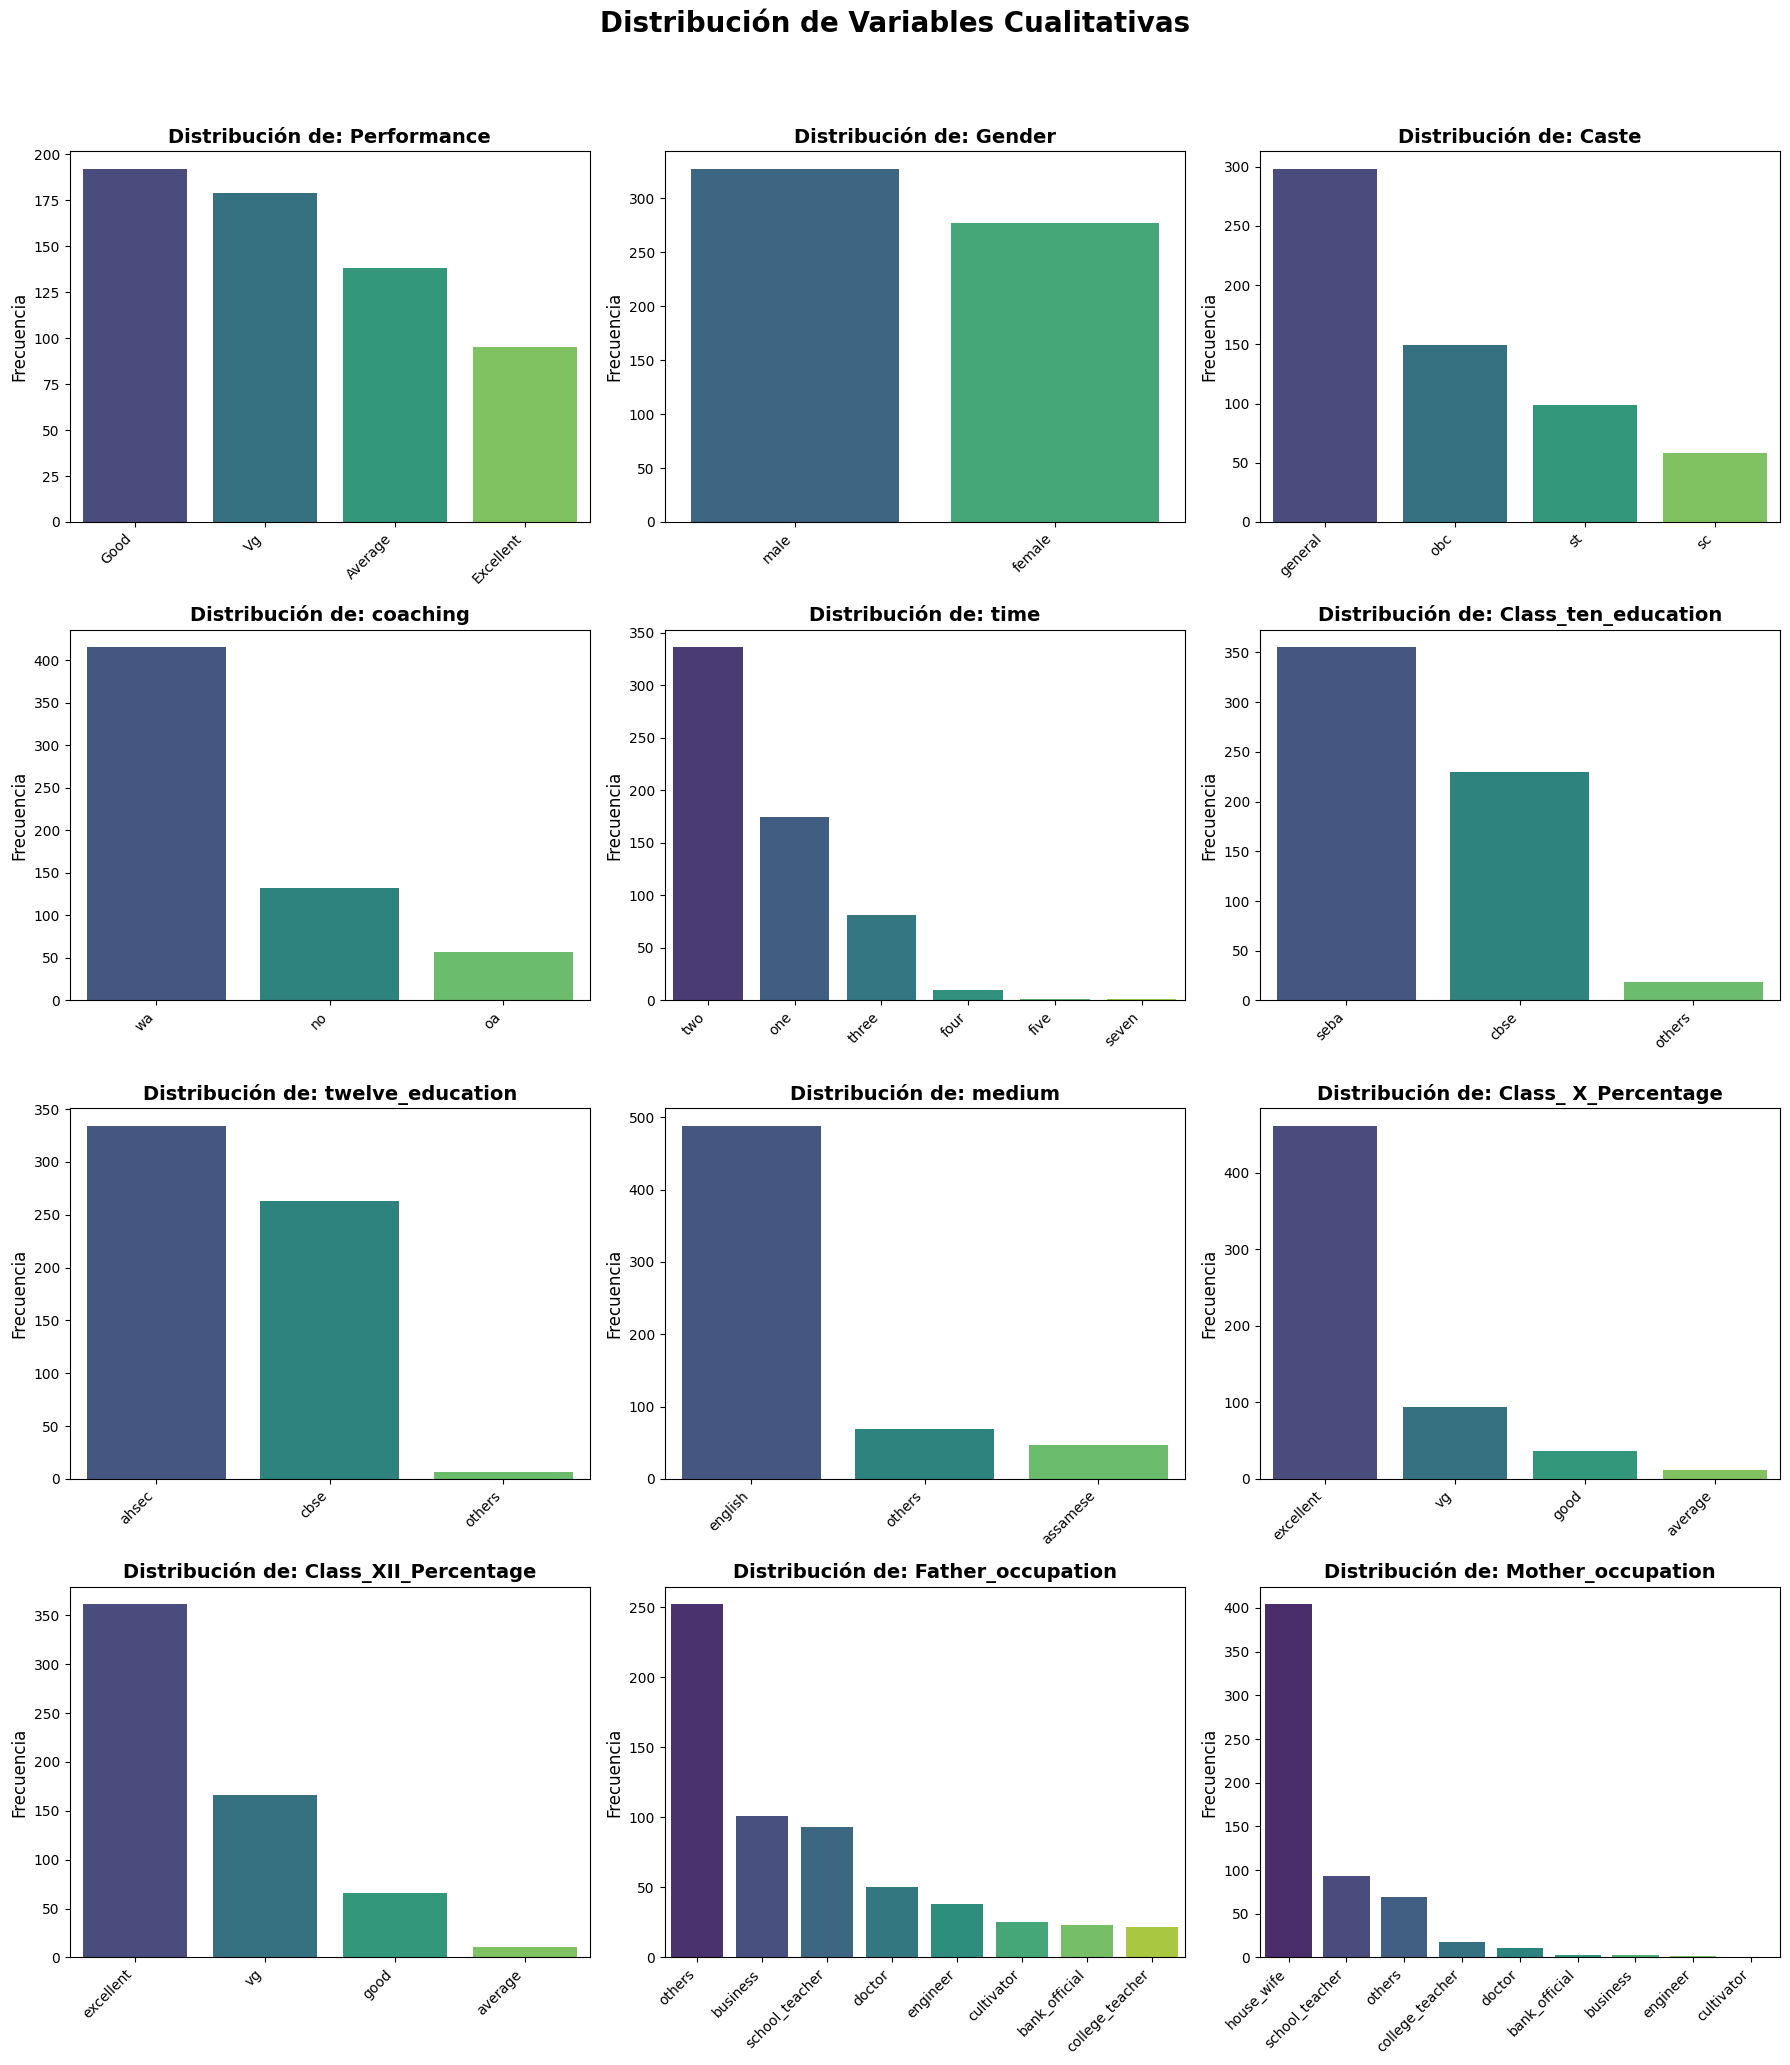

In [16]:
visualizar_cualitativas(df_limpio_2)

#--- Análisis Gráfico Variable Objetivo ---

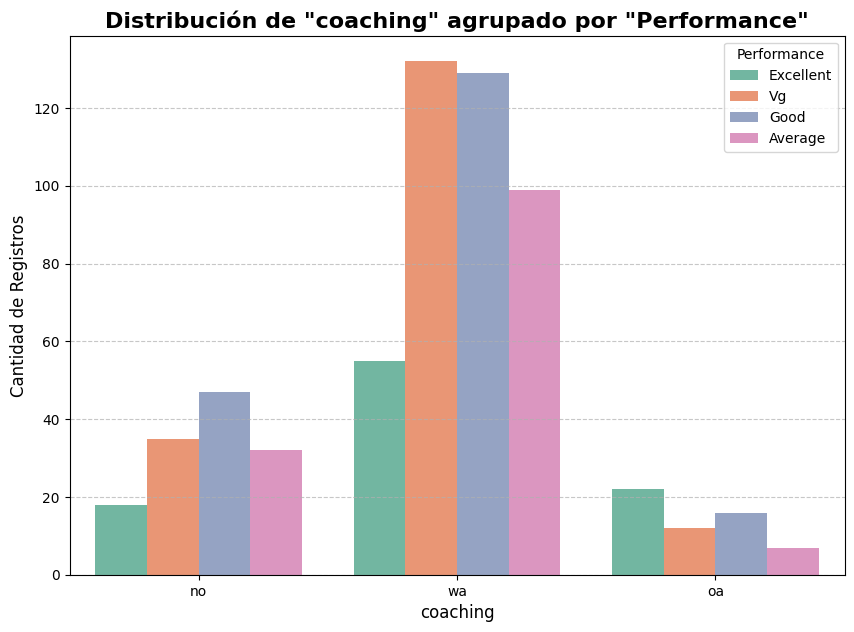

In [17]:
plot_grouped_countplot(df=df_limpio_2, x_col='coaching', hue_col='Performance')

#--- Exportar datos limpios ---

In [31]:
df_limpio_2.to_csv('student_entry_performance_clean.csv', index=False)

#--- Resumen ---

En primer lugar, se realizó una revisión inicial de los datos donde se pudo notar que existían irregularidades en los datos, también se presentaron valores nulos, esta situación se resolvió con una limpieza, además, se decidió eliminar la variable 'mixed_type_col' ya que no forma parte de las variables declaradas en el repositorio de la base de datos.

***Relación entre Coaching y Rendimiento***

El gráfico de barras profundiza en cómo el tipo de coaching se relaciona con el rendimiento final de los estudiantes. Se divide en tres grupos:

**wa (Coaching más común):**

Este es, con diferencia, el grupo más grande. La mayoría de los estudiantes del estudio pertenecen a esta categoría.

Su rendimiento se concentra en las categorías "Vg" (Muy Bueno) y "Good" (Bueno), con más de 120 estudiantes en cada una. También tienen un número considerable de estudiantes con rendimiento "Average" (Promedio) y "Excellent" (Excelente).

*Conclusión: El coaching "WA" está asociado con un alto volumen de estudiantes que obtienen buenos y muy buenos resultados.*

**no (Sin Coaching):**

Este grupo representa a los estudiantes que no tomaron ningún tipo de coaching.

Su rendimiento más frecuente es "Good" (Bueno), seguido de "Vg" (Muy Bueno) y "Average" (Promedio). Tienen el menor número de estudiantes con rendimiento "Excellent".

*Conclusión: Aunque en menor número, es posible obtener un buen rendimiento sin coaching, pero alcanzar la excelencia es menos común en este grupo.*

**oa (Otro tipo de Coaching):**

Este es el grupo más pequeño de los tres.

Lo interesante de este grupo es que, a pesar de su tamaño reducido, la categoría más alta es la de "Excellent", superando a las demás categorías de rendimiento dentro de este mismo tipo de coaching.

*Conclusión: Aunque menos popular, el coaching "OA" parece estar proporcionalmente más asociado con un rendimiento de excelencia.*

#Comparativo con Dataset Original

In [18]:
try:
    df_orignal = pd.read_csv('student_entry_performance_original.csv')
except FileNotFoundError:
    print("Asegúrate de que el archivo esté disponible.")
    exit()


In [19]:
resumen_eda_categoricas(df_orignal)

---

## **Análisis Exploratorio de Variables Categóricas**

---

### 1. Dimensiones del Dataset

Número de Filas:    666
Número de Columnas Categóricas: 12 (de un total de 12)




### 2. Muestra Aleatoria de Datos

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
33,Excellent,male,General,WA,TWO,SEBA,AHSEC,ASSAMESE,Excellent,Excellent,OTHERS,HOUSE_WIFE
508,Average,male,OBC,WA,THREE,SEBA,AHSEC,ASSAMESE,Vg,Good,BUSINESS,HOUSE_WIFE
622,Average,female,ST,WA,TWO,CBSE,CBSE,ENGLISH,Excellent,Excellent,OTHERS,HOUSE_WIFE
12,Excellent,female,General,WA,TWO,SEBA,AHSEC,ENGLISH,Excellent,Excellent,BANK_OFFICIAL,SCHOOL_TEACHER
295,Vg,male,SC,WA,ONE,OTHERS,AHSEC,ENGLISH,Excellent,Excellent,ENGINEER,HOUSE_WIFE


### 3. Calidad de los Datos

Conteo de valores nulos por columna:
No se encontraron valores nulos.




### 4. Resumen de Variables Categóricas

,count,unique,top,freq
Performance,666,4,Good,210
Gender,666,2,male,355
Caste,666,4,General,329
coaching,666,3,WA,449
time,666,6,TWO,368
Class_ten_education,666,3,SEBA,396
twelve_education,666,3,AHSEC,368
medium,666,3,ENGLISH,536
Class_ X_Percentage,666,4,Excellent,511
Class_XII_Percentage,666,4,Excellent,398


--- Generando visualizaciones para variables cualitativas ---


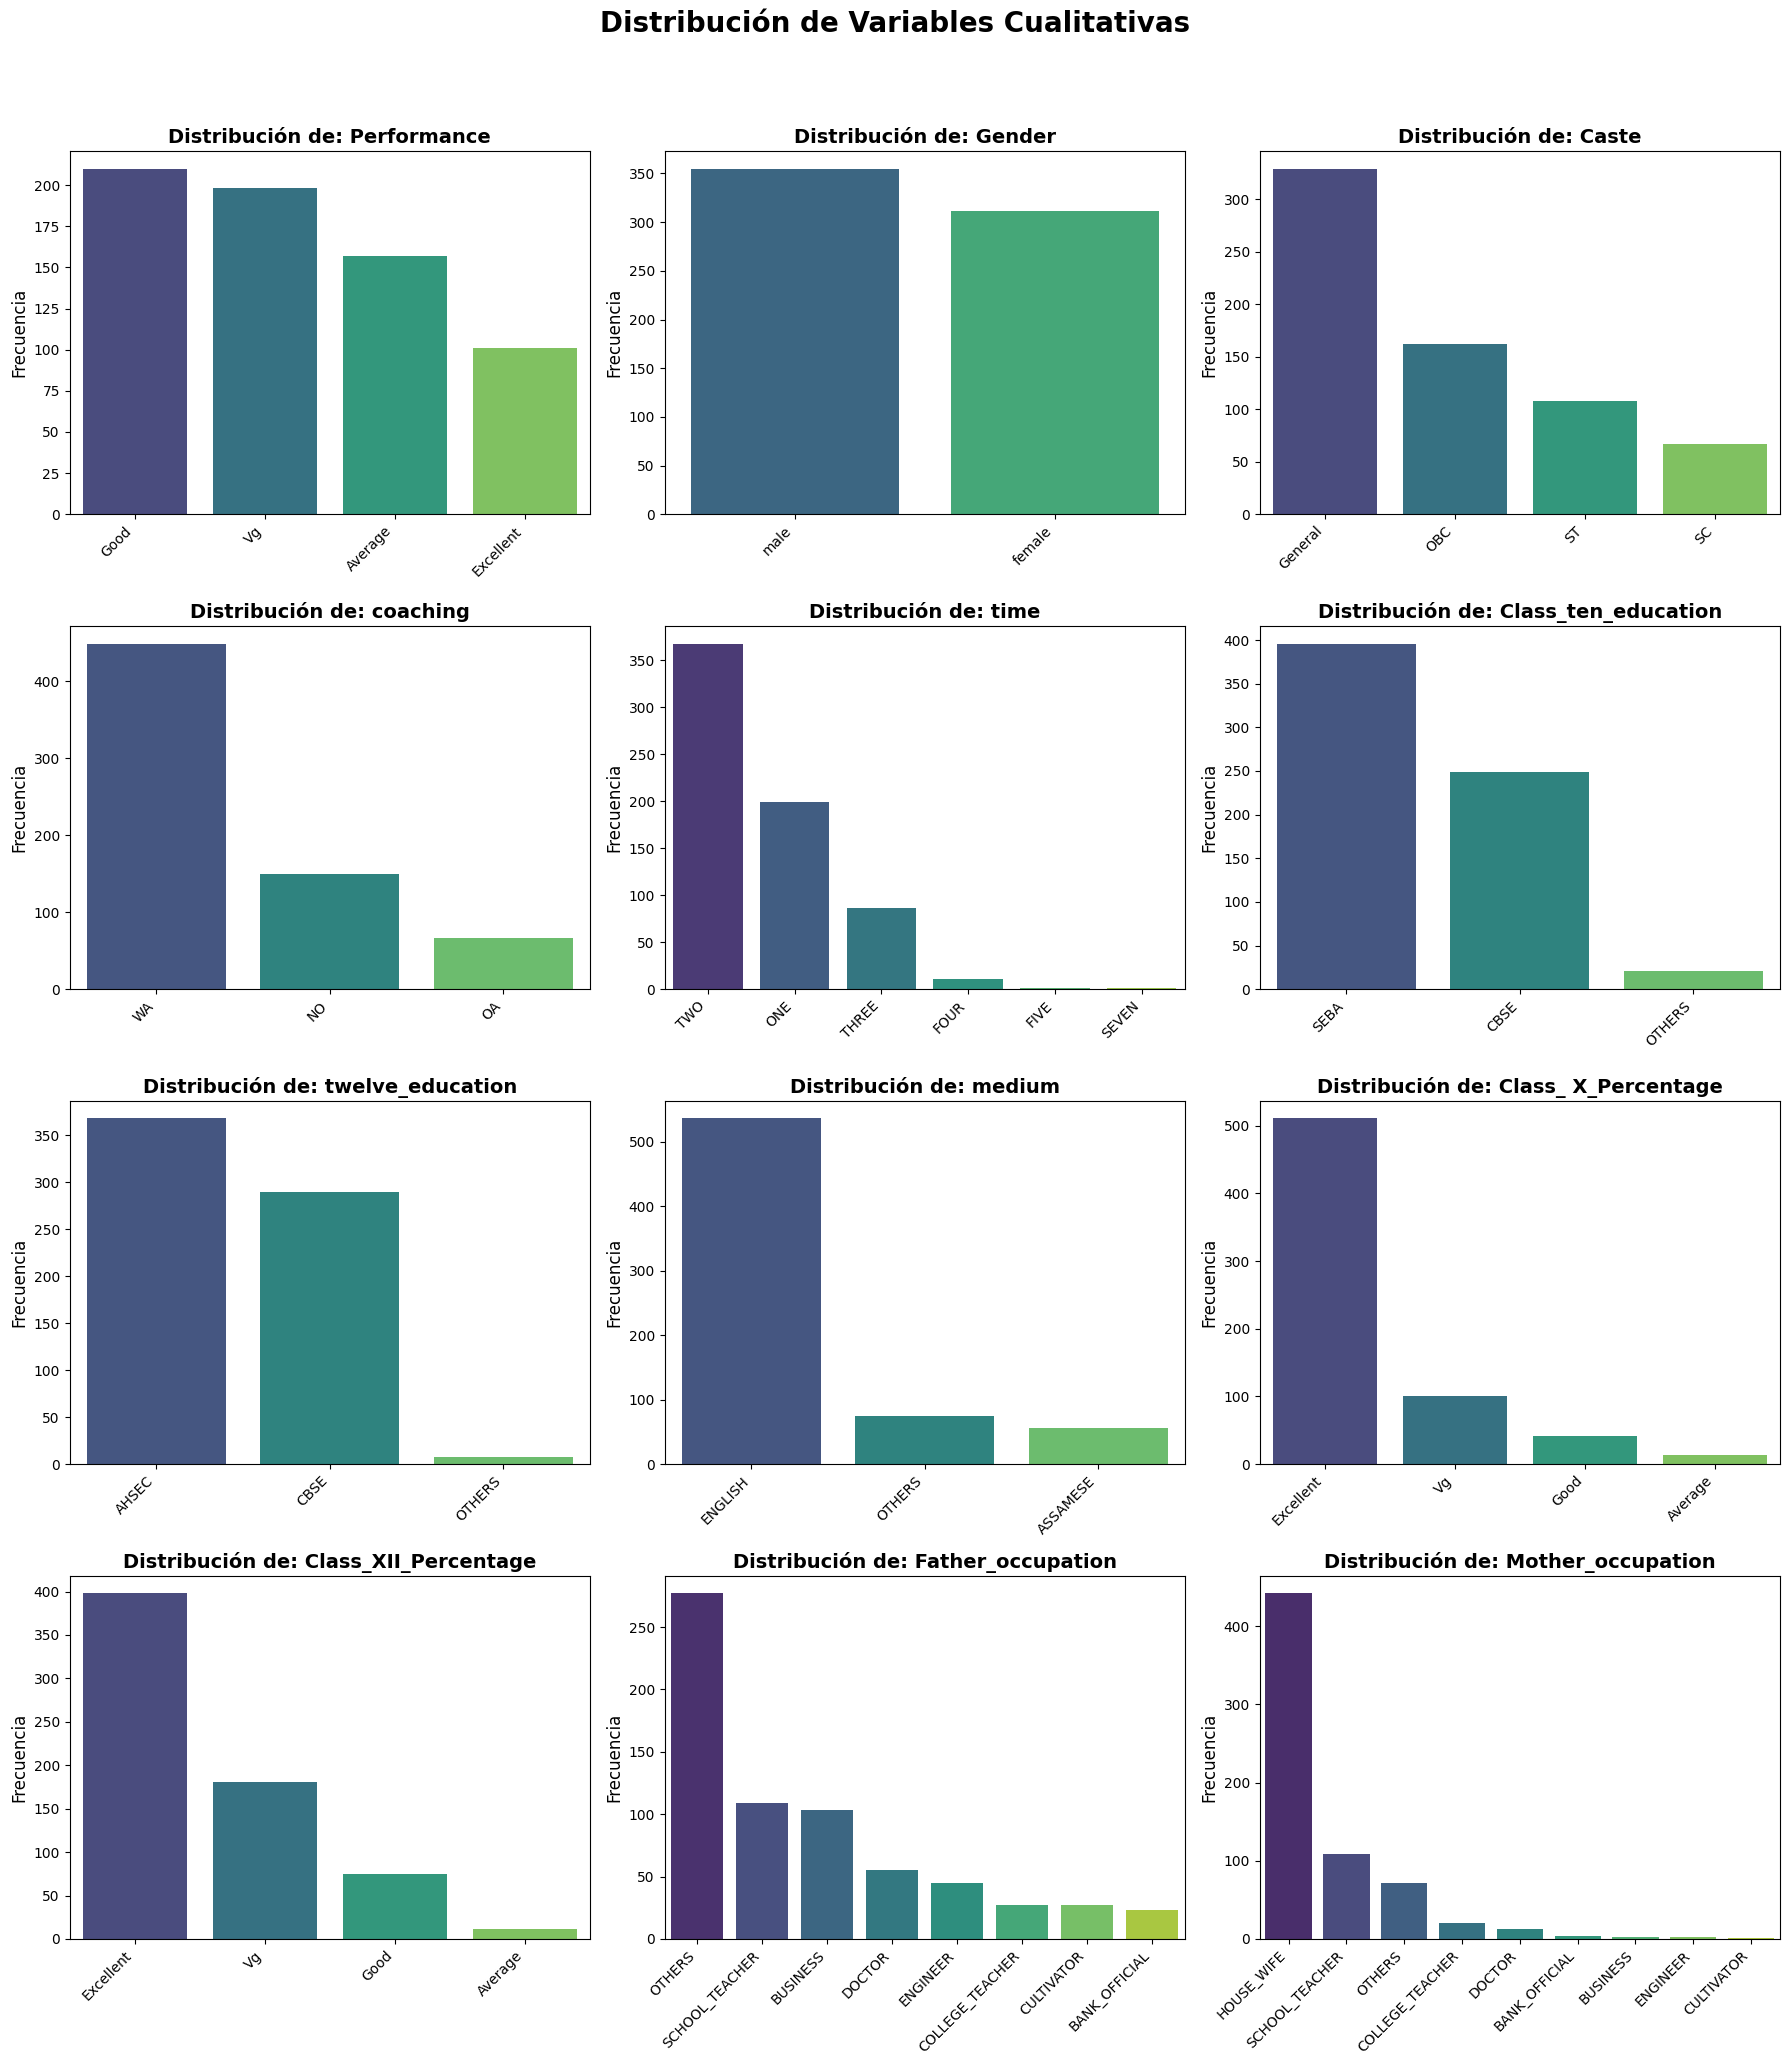

In [20]:
visualizar_cualitativas(df_orignal)

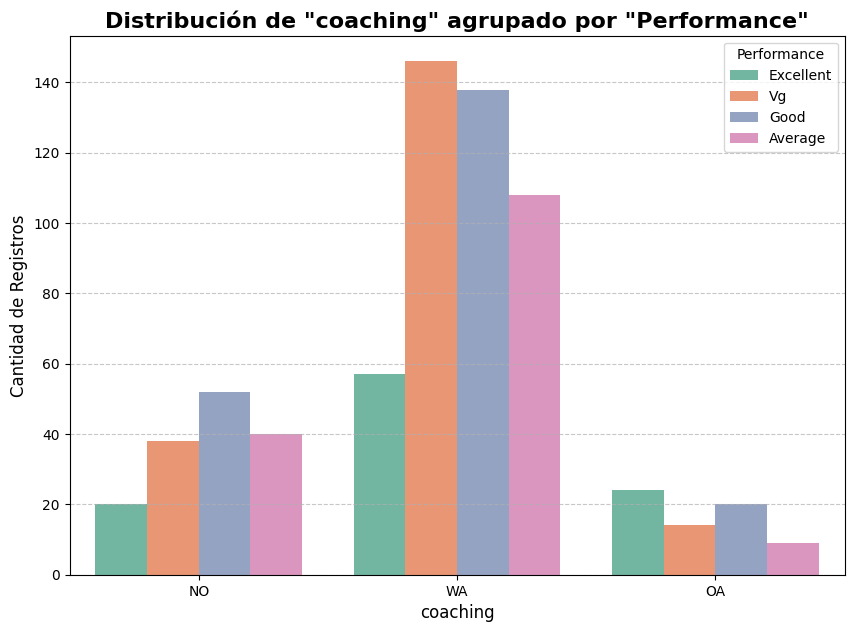

In [21]:
plot_grouped_countplot(df=df_orignal, x_col='coaching', hue_col='Performance')
